In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from collections import Counter
import requests
import random
import math
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [3]:
frequencies_url = "https://data.nextstrain.org/ncov_global_tip-frequencies.json"
frequencies = requests.get(frequencies_url).json()

In [6]:
frequency_arrays = {
    strain: np.array(strain_frequencies["frequencies"])
    for strain, strain_frequencies in frequencies.items()
    if "frequencies" in strain_frequencies
}

In [4]:
pivots = np.array(frequencies.pop("pivots"))

In [7]:
for node in tree.find_clades(order="postorder"):
    if node.is_terminal():
        # We already know the frequencies of each terminal node, so
        # store those frequencies with the corresponding node of the tree.
        node.frequencies = frequency_arrays[node.name]
    else:
        # For each internal node, sum the frequencies of its immediate
        # children. Since we are walking through the tree from the bottom
        # up, each child node will always have frequencies calculated
        # before its parent node.
        node.frequencies = np.array([
            child.frequencies
            for child in node.clades
        ]).sum(axis=0)

In [16]:
wildtype_freqs = {}
emerging_lineage_freqs = {}
for node in tree.find_clades(terminal=False):
    if "emerging_lineage" in node.node_attrs:
        if node.node_attrs["emerging_lineage"]["value"] == 'unassigned':
            wildtype_freqs[node.name] = node
        else:
            emerging_lineage_freqs[node.name] = node

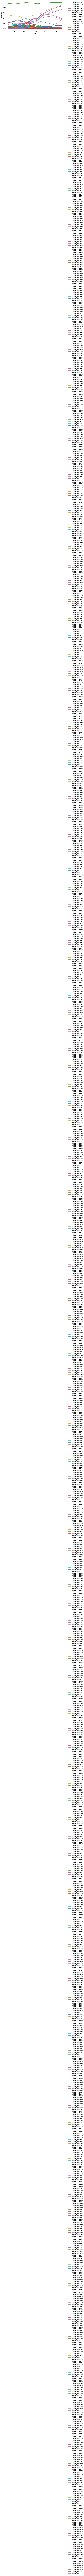

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in wildtype_freqs.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

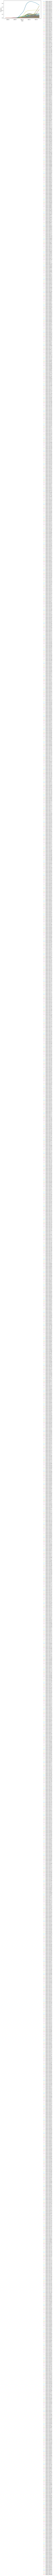

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in emerging_lineage_freqs.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)